In [1]:
cd ..

/home/martin/inference_langevin


### Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle as pkl
import networkx as nx

from topology_inference import langevin as lang
import topology_inference.utils as ut

# np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float64)

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### Data creation

In [10]:
seed = 12
torch.manual_seed(seed)
np.random.seed(seed)
graph_type = "deezer_ego"

model_files = {
    "deezer_ego": ("edp_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
                   "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi": ("edp_gnn/exp/barabasi_albert_diff_nodes/edp-gnn_barabasi_albert_[47, 49, 51, 53]__Jun-13-10-13-20_999031/models/" + 
                 "barabasi_albert_[47, 49, 51, 53]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi_smaller": ("edp_gnn/exp/barabasi_albert_diff_nodes_small/edp-gnn_barabasi_albert_[15, 17, 19, 21, 23]__Aug-07-15-50-45_2986529/models/" + 
                         "barabasi_albert_[15, 17, 19, 21, 23]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "grids": ("edp_gnn/exp/grids_dif_nodes/edp-gnn_grids_dif_nodes__Feb-12-22-48-21_4158697/models/" +
              "grids_dif_nodes_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")
}

if graph_type == "deezer_ego":
    with open("edp_gnn/data/test_deezer_ego.pkl", "rb") as f:
        graphs = pkl.load(f)
        g = graphs[np.random.randint(len(graphs))]
        A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
        A = torch.tensor(A)
    max_nodes = 25
elif graph_type == "barabasi":
    g = nx.dual_barabasi_albert_graph(50, 2, 4, 0.5, seed=seed)
    max_nodes = 53
elif graph_type == "barabasi_smaller":
    g = nx.dual_barabasi_albert_graph(20, 2, 4, 0.5, seed=seed)
    max_nodes = 23
elif graph_type == "grids":
    m_min = 5
    m_max = 9
    min_nodes = 40
    max_nodes = 49
    min_random_edges = 2
    max_random_edges = 5
    seed = 0
    g = ut.generate_grid_graph(m_min, m_max, min_nodes, max_nodes, min_random_edges, max_random_edges)
    max_nodes = 49

# A = torch.randint(0, 2, (5, 5)).double()
# A = torch.triu(A) + torch.triu(A, 1).T
# A.fill_diagonal_(0.0)
model_file = model_files[graph_type]
A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
A = torch.tensor(A)
# Number of nodes
p = A.shape[0]
# Number of measurements
n = 50
# Filter parameters
theta_min, theta_max = 0.3, 0.7
n_theta = 1
h_theta = ut.heat_diffusion_filter
# Variance of the noise
sigma_e = 1
# Unknown fraction of the matrix
p_unknown = 1.0

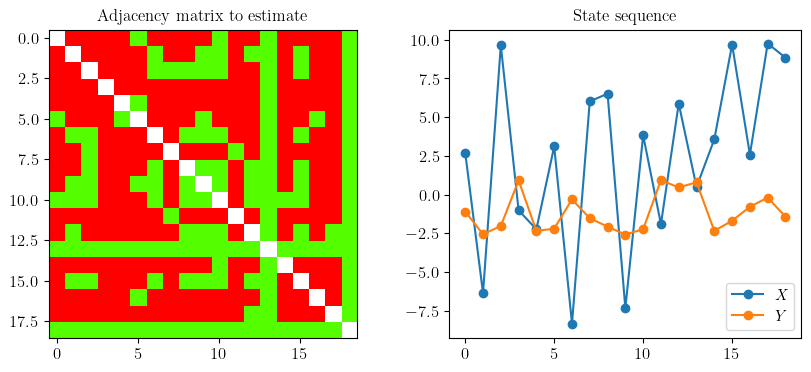

tensor([0.5100], device='cuda:0')


In [11]:
# Dynamics matrix
theta_dist = torch.distributions.Uniform(theta_min, theta_max)
theta = theta_dist.sample([n_theta])
F = h_theta(A, *theta)

# L = ut.compute_laplacian(A)

e_dist = torch.distributions.Normal(0, sigma_e)

# Generate state and measurement sequence
X = torch.empty((p, n)).uniform_(-10, 10) # * torch.empty((p, n)).bernoulli_(0.8)
Y = F @ X + e_dist.sample((p, n))

# Generate unknown adjacency matrix
A_nan = ut.create_partially_known_graph(A, p_unknown)
known_idxs = torch.where(~ torch.isnan(A_nan))
unknown_idxs = torch.where(torch.isnan(A_nan))

A_plot = A.clone()
A_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_plot[known_idxs[1], known_idxs[0]] = torch.nan

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('Adjacency matrix to estimate')
ax[1].plot(X.T.cpu()[np.random.randint(n)], "-o", label=r"$X$")
ax[1].plot(Y.T.cpu()[np.random.randint(n)], "-o", label=r"$Y$")
ax[1].set_title('State sequence')
ax[1].legend()
plt.show()
print(theta)

### KLF

In [90]:
sigmas = torch.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
temperature = 0.5
lr = 0.01
steps = 300

model = ut.load_model(model_file)
A_score_model = ut.score_edp_wrapper(model, A.shape[0], len(sigmas), max_nodes=max_nodes)
# A_score_model = lambda A, _: torch.zeros(A.shape)

langevin_est = est.LangevinEstimator(h_theta=h_theta,
                                      A_score_model=A_score_model,
                                      theta_prior_dist=theta_dist,
                                      # theta_fixed=theta,
                                      sigma_e=sigma_e)

A_lang, theta_lang, metrics = langevin_est.langevin_estimate(A_nan=A_nan, X=X, Y=Y, 
                                                             sigmas_sq=sigmas ** 2, epsilon=epsilon, 
                                                             temperature=temperature, steps=steps,
                                                             adam_lr=lr,
                                                             projection_method="copy", clip_A_tilde=True, 
                                                             true_A=A, true_theta=theta)

Real theta: tensor([ 0.0050,  0.0624, -0.0971], device='cuda:0')
Estimated theta: tensor([-0.0066,  0.0677, -0.0524], device='cuda:0')
AUCROC: 0.6358082706766918
F1: 0.18666666666666668
Rel. error: 0.9943181586634641
Normalized MSE: 0.16178917568362108


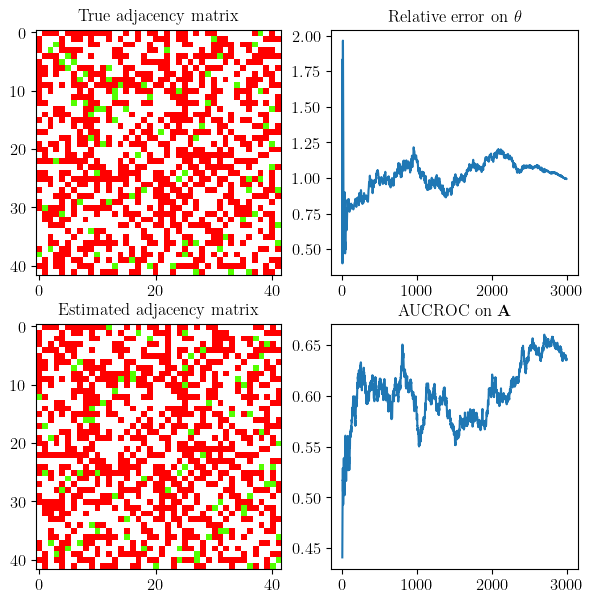

In [91]:
roc, threshold = ut.compute_aucroc(A, A_lang, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_lang > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_lang)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, A_est_plot, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_lang).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_lang).item())
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(A_plot.cpu(), cmap="prism")
ax[0, 0].set_title('True adjacency matrix')

ax[1, 0].imshow(A_est_plot.cpu(), cmap="prism")
ax[1, 0].set_title('Estimated adjacency matrix')

# ax[0, 1].set_xlabel("Iteration")
ax[0, 1].set_title(r"Relative error on $\theta$")
ax[0, 1].plot(metrics["relative_error"].cpu())

# ax[1, 1].set_xlabel("Iteration")
ax[1, 1].set_title(r"AUCROC on $\mathbf{A}$")
ax[1, 1].plot(metrics["aucroc"].cpu())

plt.show()

In [12]:
torch.manual_seed(0)
adam_est = est.AdamEstimator(h_theta=h_theta,
                              sigma_e=sigma_e, 
                              lr=0.01, n_iter=1000)
n_samples = 50
A_samples = []
theta_samples = []
for i in range(n_samples):
    A_adam, theta_adam, _ = adam_est.adam_estimate(A_nan=A_nan, X=X, Y=Y, theta_prior_dist=theta_dist, l1_penalty=0.0)
    A_samples.append(A_adam)
    theta_samples.append(theta_adam)

A_samples = torch.stack(A_samples)
theta_samples = torch.stack(theta_samples)

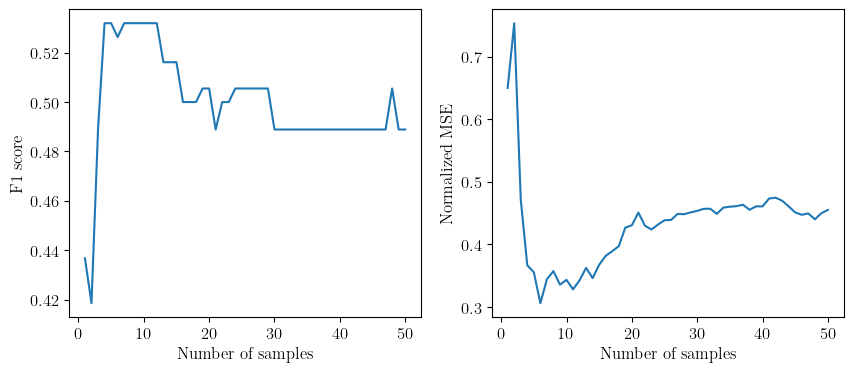

In [13]:
f1 = list()
nmse = list()

for i in range(n_samples):
    A_est = A_samples[0:i + 1].mean(dim=0)
    theta_est = theta_samples[0:i + 1].mean(dim=0)
    f1.append(ut.compute_f1(A, A_est, use_idxs=unknown_idxs))
    nmse.append(ut.compute_normalized_mse(theta, theta_est).item())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(np.arange(n_samples) + 1, f1)
ax[0].set_ylabel("F1 score")
ax[0].set_xlabel("Number of samples")
ax[1].plot(np.arange(n_samples) + 1, nmse)
ax[1].set_ylabel("Normalized MSE")
ax[1].set_xlabel("Number of samples")
plt.show()